# Customer churn Analysis Project

Problem statement

Customer churn is when a company’s customers stop doing business with that company. Businesses are very keen on measuring churn because keeping an existing customer is far less expensive than acquiring a new customer. New business involves working leads through a sales funnel, using marketing and sales budgets to gain additional customers. Existing customers will often have a higher volume of service consumption and can generate additional customer referrals.

Customer retention can be achieved with good customer service and products. But the most effective way for a company to prevent attrition of customers is to truly know them. The vast volumes of data collected about customers can be used to build churn prediction models. Knowing who is most likely to defect means that a company can prioritise focused marketing efforts on that subset of their customer base.

Preventing customer churn is critically important to the telecommunications sector, as the barriers to entry for switching services are so low. 

You will examine customer data from IBM Sample Data Sets with the aim of building and comparing several customer churn prediction models. 

In [2]:
# First of all importing all the necessary libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats as stats
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import recall_score, accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest
from imblearn.combine import SMOTEENN
from collections import Counter

# importing to ignore warning
import warnings
warnings.filterwarnings('ignore')
import matplotlib.ticker as mtick # importing to show percentage in it

In [3]:
data = pd.read_csv('Telecom_customer_churn.csv')
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
# Type of feature

data.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

From above, we can see that some of the independent features are in numerical and most of the features are in categorical feature. Seperating into numerical and categorical data for EDA parts

In [5]:
# Total charges are in object data type so converting into Numerical feature 
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')

In [6]:
# Separating into numerical and categorical features

# numerical feature
numerical_feature = {feature for feature in data.columns if data[feature].dtypes != 'O'}
print(f'Count of Numerical feature: {len(numerical_feature)}')
print(f'Numerical feature are:\n {numerical_feature}')

Count of Numerical feature: 4
Numerical feature are:
 {'MonthlyCharges', 'SeniorCitizen', 'TotalCharges', 'tenure'}


In [7]:
# categorical feature
categorical_feature = {feature for feature in data.columns if data[feature].dtypes == 'O'}
print(f'Count of Categorical feature: {len(categorical_feature)}')
print(f'Categorical feature are:\n {categorical_feature}')

Count of Categorical feature: 17
Categorical feature are:
 {'customerID', 'InternetService', 'DeviceProtection', 'gender', 'TechSupport', 'Partner', 'PhoneService', 'MultipleLines', 'OnlineSecurity', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'OnlineBackup', 'StreamingTV', 'StreamingMovies', 'Churn', 'Dependents'}


# Exploratory Data Analysis

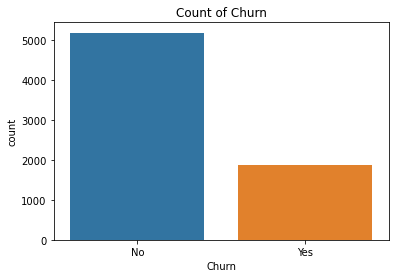

In [8]:
# First plotting with the target feature
sns.countplot(data=data, x='Churn')
plt.title('Count of Churn')
plt.show()

In [9]:
l1 = data.loc[data['Churn']== 'Yes'].count()[0]
print(f"Pecentage of Left: {l1/len(data['Churn'])}")
print(data.Churn.value_counts())

Pecentage of Left: 0.2653698707936959
No     5174
Yes    1869
Name: Churn, dtype: int64


1869 of customer left about 26.5 percentage from overall, this is like an imbalance dataset.

In [10]:
# How much amount loss from customer churn
loss = []
for values in data.loc[data['Churn'] == 'Yes', 'TotalCharges']:
    value = float(values)
    loss.append(value)
print(np.round(sum(loss)))

2862927.0


We have lost arround $2862927 due to customer churn

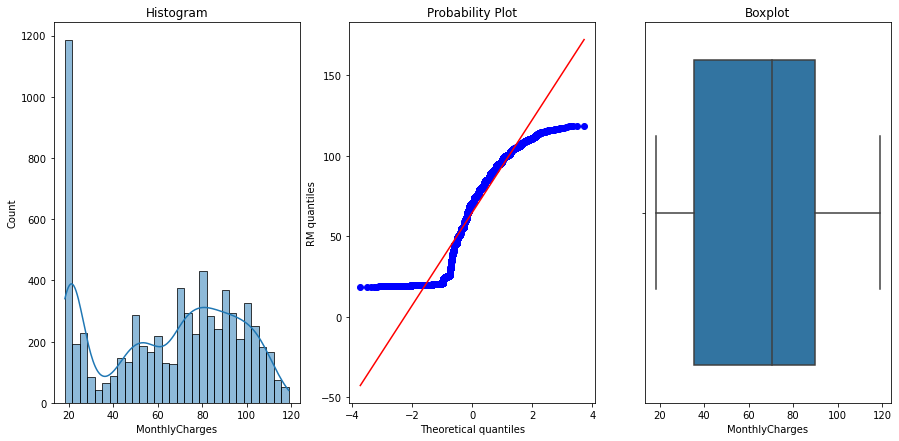

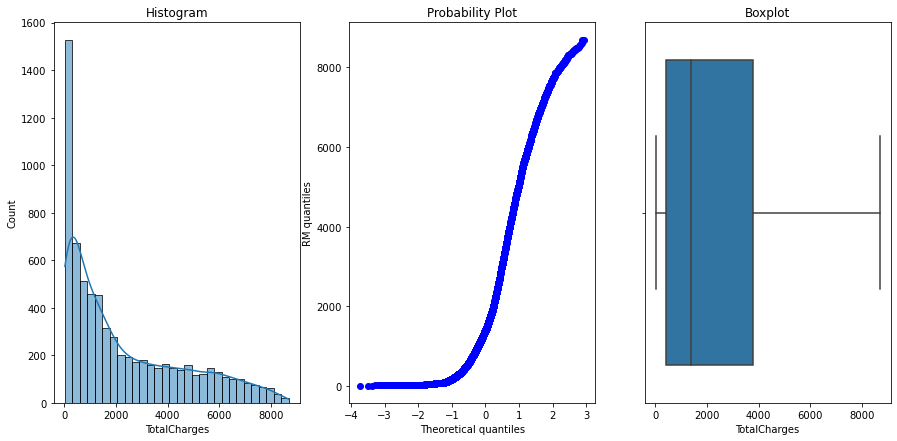

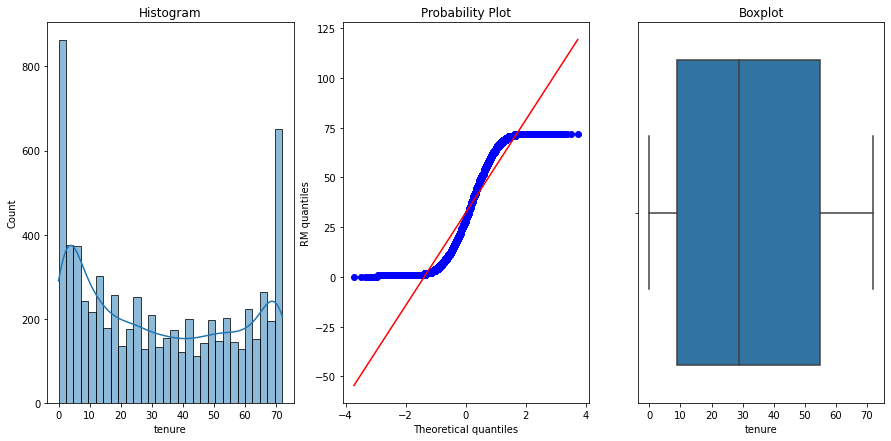

In [11]:
# Plotting numerical feature with probability distribution and checking outlier
for feature in numerical_feature:
    if feature != 'SeniorCitizen':
        plt.figure(figsize=(15,7))
    
        plt.subplot(1, 3, 1)
        sns.histplot(data=data, x=feature, bins=30, kde=True)
        plt.title('Histogram')
    
        plt.subplot(1, 3, 2)
        stats.probplot(data[feature], dist="norm", plot=plt)
        plt.ylabel('RM quantiles')
    
        plt.subplot(1, 3, 3)
        sns.boxplot(x=data[feature])
        plt.title('Boxplot')
    
plt.show()

After ploting the histogram probability distribution and box plot to find numerical value are in normally distribution and our dataset has no outlier dataset.So, we don't want to remove the outlier in our dataset.

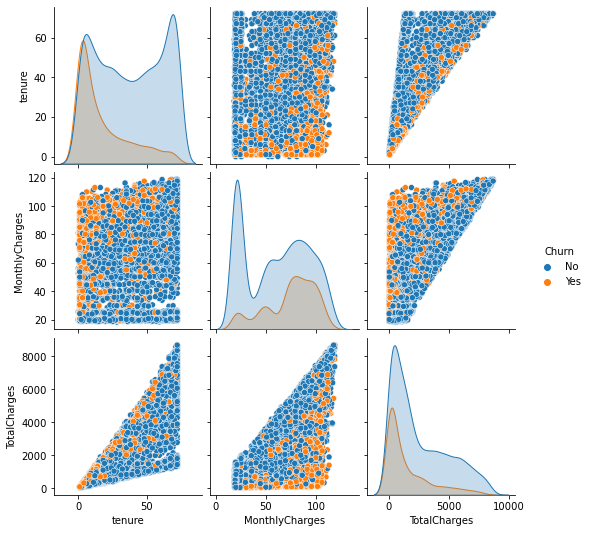

In [12]:
sns.pairplot(data.drop(columns='SeniorCitizen'),hue='Churn', kind='scatter')
plt.show()

Text(0.5, 1.0, '% of Senior Citizens')

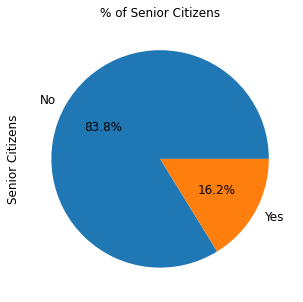

In [13]:
# pie chart for the Count of Senior citizens
ax = (data['SeniorCitizen'].value_counts()*100.0 /len(data)).plot.pie(autopct='%.1f%%', labels = ['No', 'Yes'],figsize =(5,5), fontsize = 12 )                                                                           
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_ylabel('Senior Citizens',fontsize = 12)
ax.set_title('% of Senior Citizens', fontsize = 12)

Only 16.2% customers who are senior citizens but remaining 83.8% customers are young people.

<Figure size 432x288 with 0 Axes>

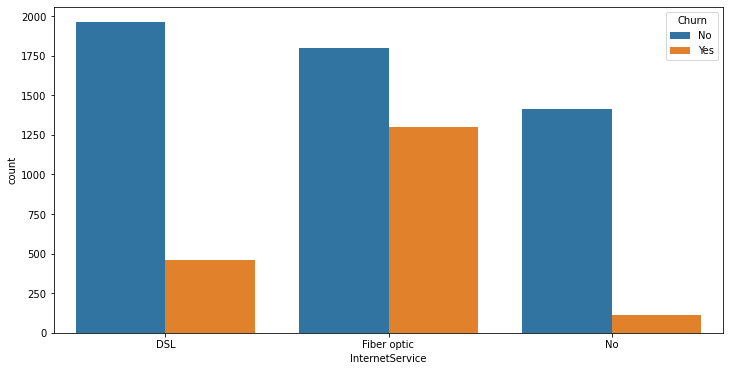

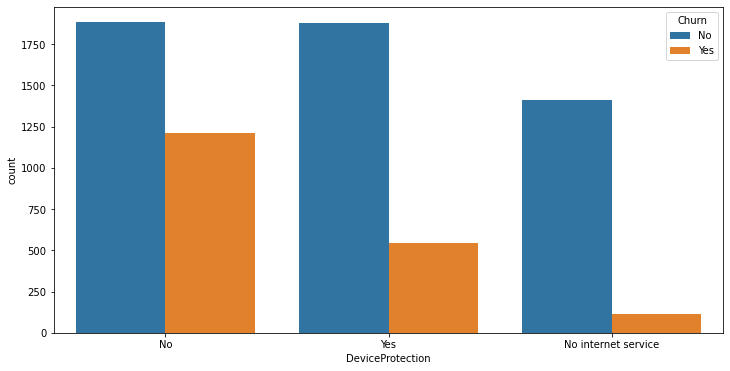

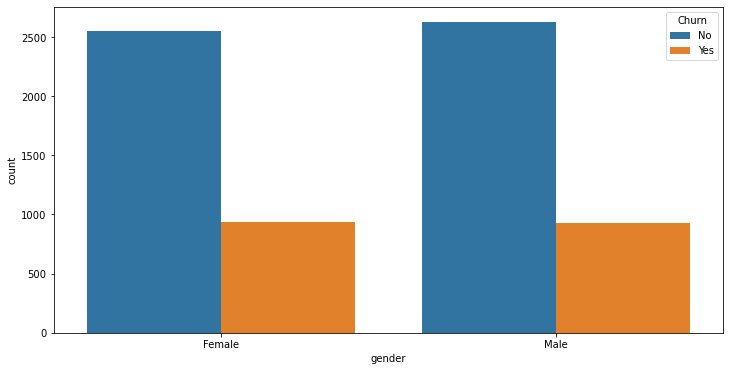

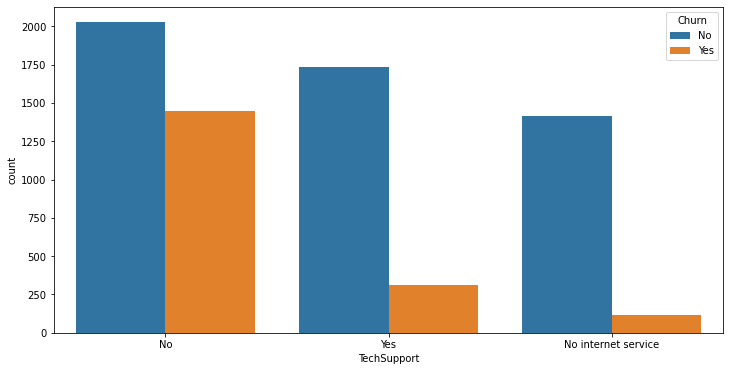

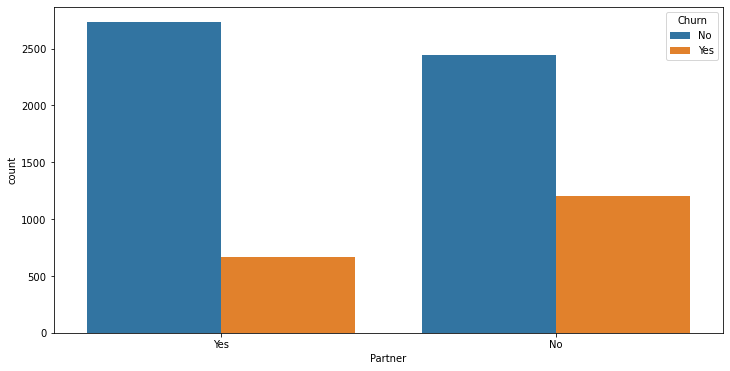

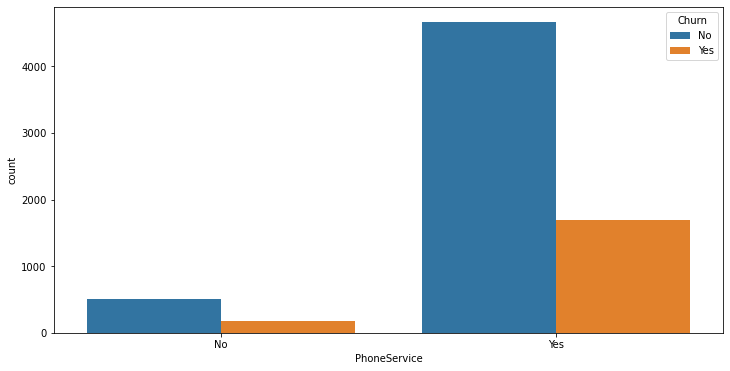

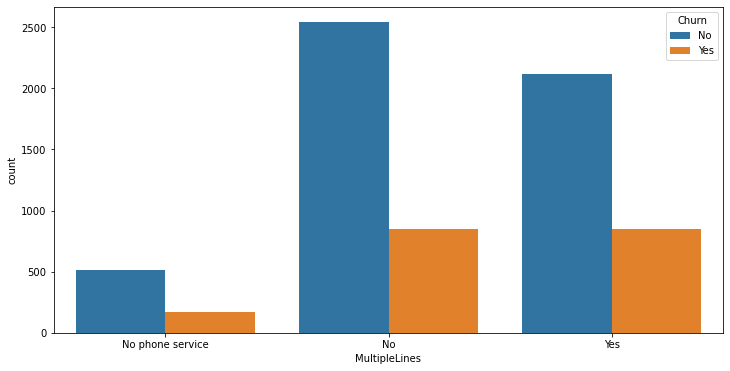

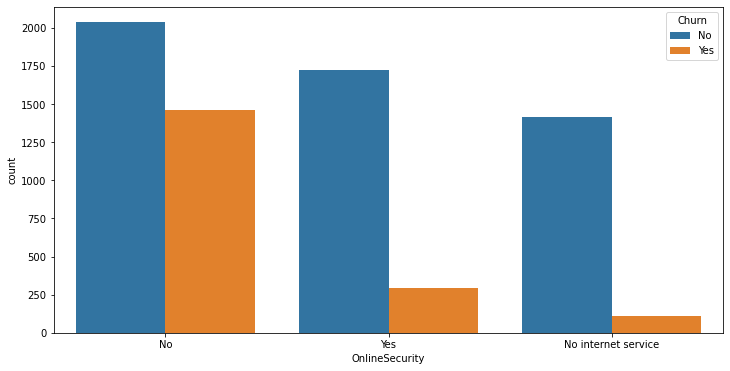

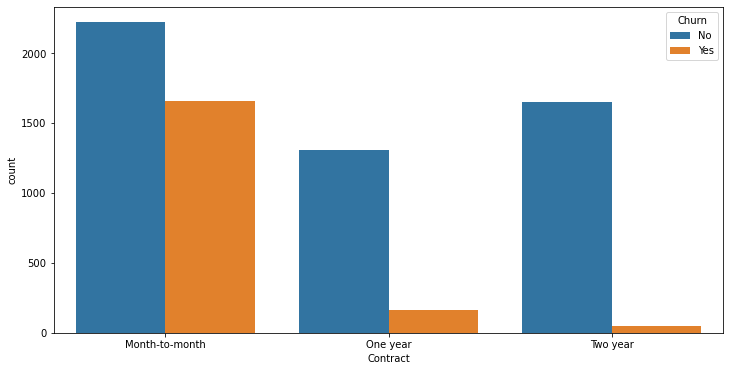

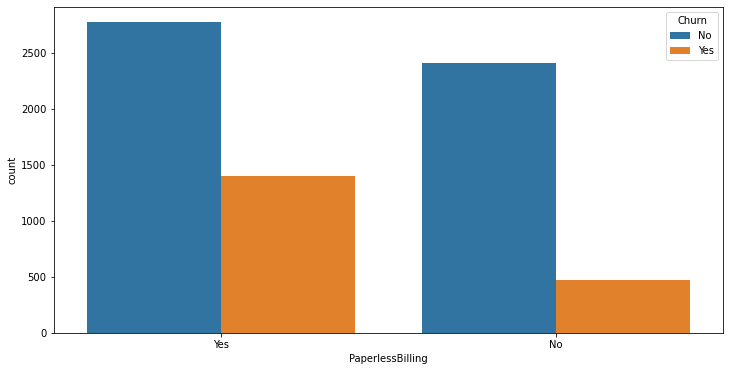

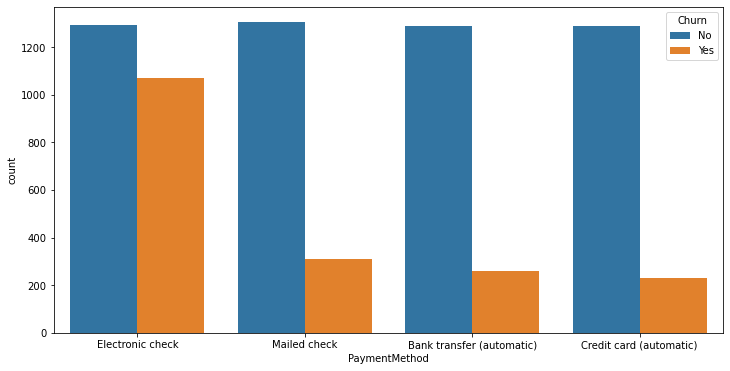

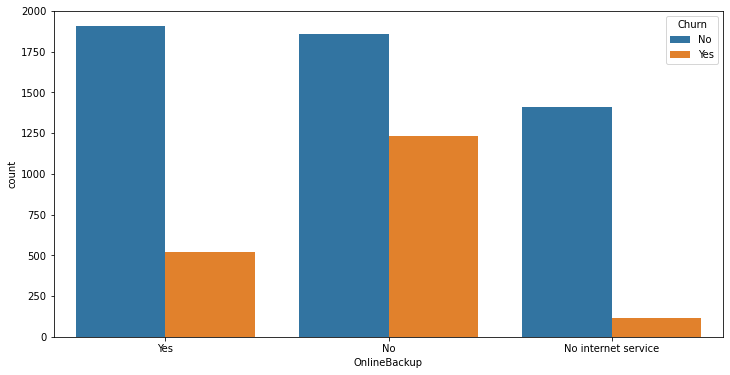

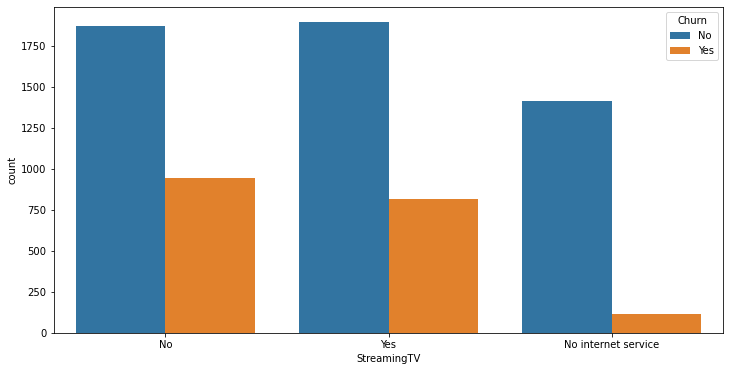

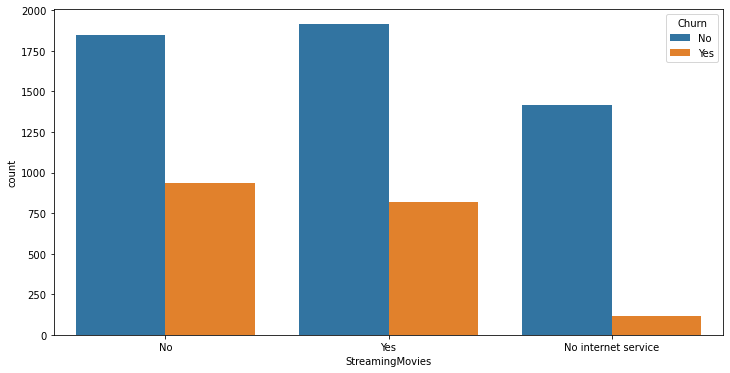

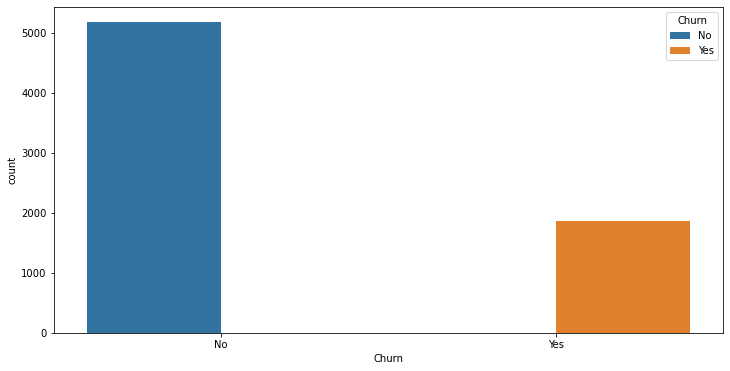

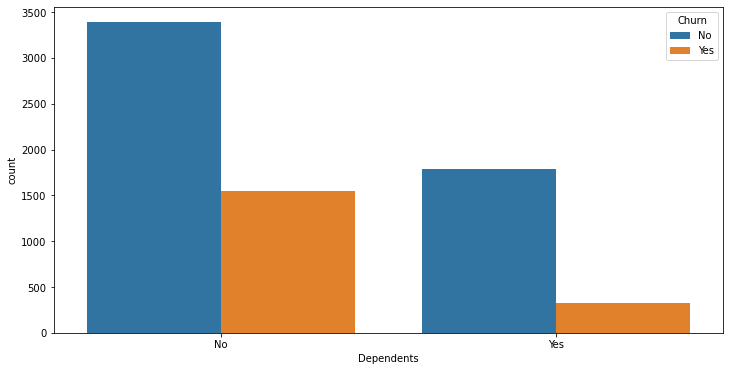

In [14]:
# Doing Univariate Analysis
for i, feature in enumerate(categorical_feature):
    if feature != 'TotalCharges':
        if feature != 'customerID':
            plt.figure(i)
            plt.figure(figsize=(12,6))
            sns.countplot(data=data, x=feature, hue='Churn')
plt.show()

In [15]:
# Performing Data cleaning

data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [16]:
data.isnull().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [17]:
# Upon replacing NaN values with mean value
data.TotalCharges = data.TotalCharges.fillna(data.TotalCharges.median())

<AxesSubplot:>

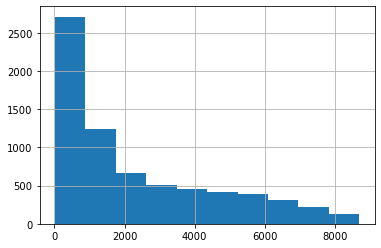

In [18]:
data.TotalCharges.hist()

In this dataset there are no null values, so we dont want to perform Handling missing values. Only performing the Feature Encoding techiniques to convert the categorical feature into numerical feature.

In [19]:
print(categorical_feature)

{'customerID', 'InternetService', 'DeviceProtection', 'gender', 'TechSupport', 'Partner', 'PhoneService', 'MultipleLines', 'OnlineSecurity', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'OnlineBackup', 'StreamingTV', 'StreamingMovies', 'Churn', 'Dependents'}


In [20]:
encoder = LabelEncoder()
for feature in categorical_feature:
    data[feature] = encoder.fit_transform(data[feature])
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,5375,0,0,1,0,1,0,1,0,0,...,0,0,0,0,0,1,2,29.85,29.85,0
1,3962,1,0,0,0,34,1,0,0,2,...,2,0,0,0,1,0,3,56.95,1889.50,0
2,2564,1,0,0,0,2,1,0,0,2,...,0,0,0,0,0,1,3,53.85,108.15,1
3,5535,1,0,0,0,45,0,1,0,2,...,2,2,0,0,1,0,0,42.30,1840.75,0
4,6511,0,0,0,0,2,1,0,1,0,...,0,0,0,0,0,1,2,70.70,151.65,1


In [21]:
data.drop(columns=['customerID'], inplace=True)

<AxesSubplot:>

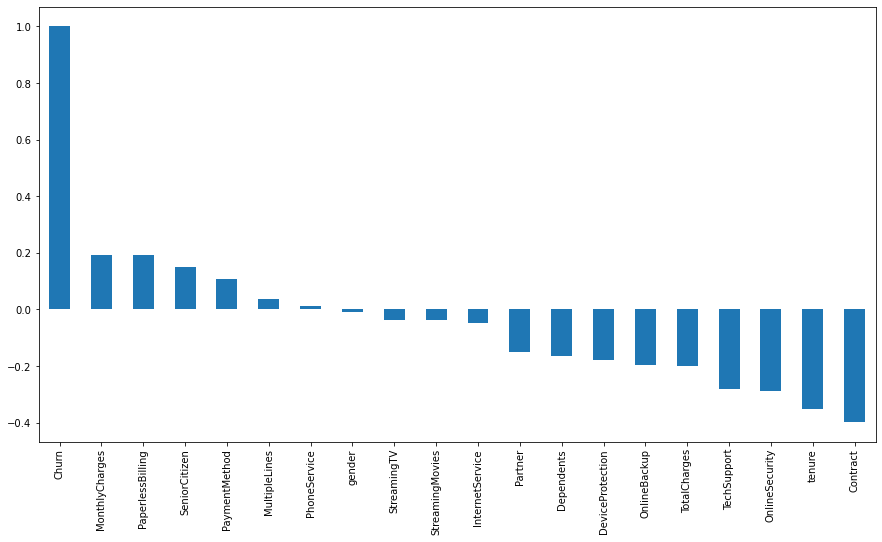

In [22]:
#Getting Correlation of "Churn" with other variables:

plt.figure(figsize=(15,8))
data.corr()['Churn'].sort_values(ascending = False).plot(kind='bar')

<AxesSubplot:>

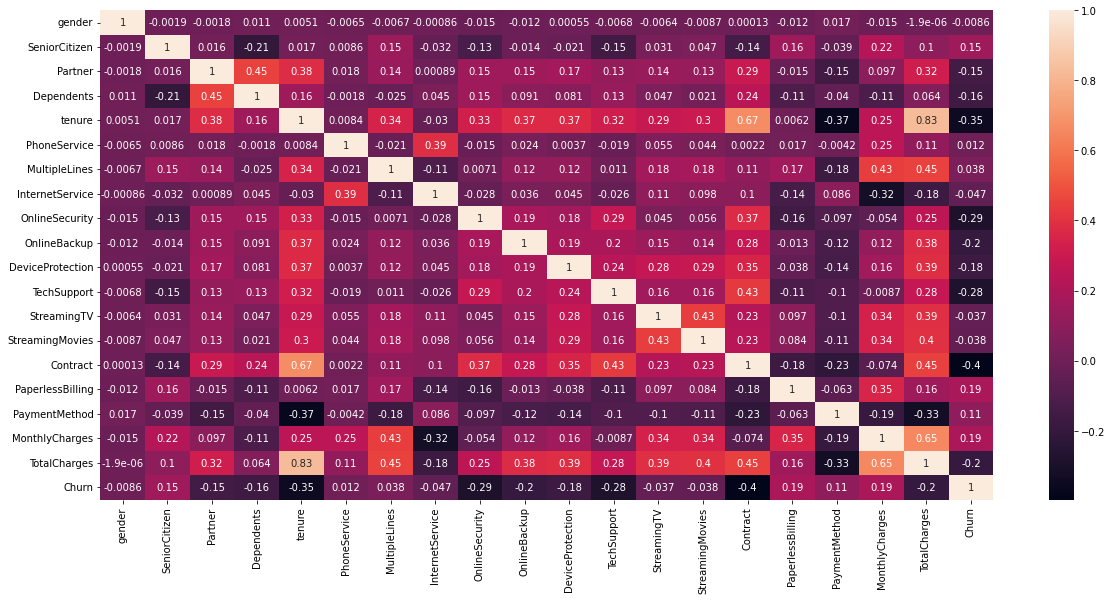

In [23]:
# To find the correlation between independent and dependent feature.

plt.figure(figsize=(20, 9))
sns.heatmap(data.corr(), annot=True)

We will be using ensemble methods, So there is no need to perform feature scaling for ensemble techniques, its prediction based on creating multiple decision trees.

In [24]:
# Spliting the data set into train and test

# splitting dataset into dependent and independent feature
X = data.drop(columns='Churn')
y = data['Churn']
X.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,0,0,1,0,1,0,1,0,0,2,0,0,0,0,0,1,2,29.85,29.85
1,1,0,0,0,34,1,0,0,2,0,2,0,0,0,1,0,3,56.95,1889.50
2,1,0,0,0,2,1,0,0,2,2,0,0,0,0,0,1,3,53.85,108.15
3,1,0,0,0,45,0,1,0,2,0,2,2,0,0,1,0,0,42.30,1840.75
4,0,0,0,0,2,1,0,1,0,0,0,0,0,0,0,1,2,70.70,151.65


# Feature Selection

In [25]:
# Selecting only 10 features that high coorelation
# selecting the feature which has more correlation

selection = SelectKBest()  # k=10 default
X = selection.fit_transform(X,y)

In [26]:
#  this will show that which feature is taken and denoting as True other is removed like false
selection.get_support()

array([False, False, False,  True,  True, False, False, False,  True,
        True,  True,  True, False, False,  True,  True, False,  True,
        True])

According to the feature selection, we have selected 10 out of 21 features. these are the 10 features that areselected [Dependents, tenure, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, Contract, PaperlessBilling, MonthlyCharges, TotalCharges]

From sklearn using feature selection modules importing the SelectKBest to select the important feature

In [27]:
# splitting for train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train.shape

(5634, 10)

In [28]:
X_test.shape

(1409, 10)

In [29]:
# it is an imbalance dataset
y.value_counts()

0    5174
1    1869
Name: Churn, dtype: int64

# Applying Machine learning Algorithms

In [30]:
Log_reg = LogisticRegression(C=150, max_iter=150)
Log_reg.fit(X_train, y_train)
log_pred = Log_reg.predict(X_test)

print(f'Accuracy score : {accuracy_score(log_pred, y_test)}')
print(f'Confusion matrix :\n {confusion_matrix(log_pred, y_test)}')
print(f'Classification report :\n {classification_report(log_pred, y_test)}')

Accuracy score : 0.7849538679914834
Confusion matrix :
 [[908 184]
 [119 198]]
Classification report :
               precision    recall  f1-score   support

           0       0.88      0.83      0.86      1092
           1       0.52      0.62      0.57       317

    accuracy                           0.78      1409
   macro avg       0.70      0.73      0.71      1409
weighted avg       0.80      0.78      0.79      1409



In [31]:
# Random forest classifier

Rfc = RandomForestClassifier(n_estimators=120,criterion='gini', max_depth=15, min_samples_leaf=10, min_samples_split=5)
Rfc.fit(X_train, y_train)
rfc_pred = Rfc.predict(X_test)

print(f'Accuracy score : {accuracy_score(rfc_pred, y_test)}')
print(f'Confusion matrix :\n {confusion_matrix(rfc_pred, y_test)}')
print(f'Classification report :\n {classification_report(rfc_pred, y_test)}')

Accuracy score : 0.7892122072391767
Confusion matrix :
 [[949 219]
 [ 78 163]]
Classification report :
               precision    recall  f1-score   support

           0       0.92      0.81      0.86      1168
           1       0.43      0.68      0.52       241

    accuracy                           0.79      1409
   macro avg       0.68      0.74      0.69      1409
weighted avg       0.84      0.79      0.81      1409



In [32]:
# DecisionTree Classifier

Dtc = DecisionTreeClassifier(criterion='gini', splitter='random', min_samples_leaf=15)
Dtc.fit(X_train, y_train)
dtc_pred = Dtc.predict(X_test)

print(f'Accuracy score : {accuracy_score(dtc_pred, y_test)}')
print(f'Confusion matrix :\n {confusion_matrix(dtc_pred, y_test)}')
print(f'Classification report :\n {classification_report(dtc_pred, y_test)}')

Accuracy score : 0.7714691270404542
Confusion matrix :
 [[926 221]
 [101 161]]
Classification report :
               precision    recall  f1-score   support

           0       0.90      0.81      0.85      1147
           1       0.42      0.61      0.50       262

    accuracy                           0.77      1409
   macro avg       0.66      0.71      0.68      1409
weighted avg       0.81      0.77      0.79      1409



As we are comparing to the imbalance dataset our model is performing like okay but not a better model. To build a end to end project. We need to over sampling data for reducing the TN, FN and increase the FP and TP for model building.

In [33]:
# Upon using SMOTEENN for imbalance dataset
#Over-sampling using SMOTE and cleaning using ENN. Combine over- and under-sampling using SMOTE and Edited Nearest Neighbours

st=SMOTEENN()
X_train_st,y_train_st = st.fit_resample(X_train, y_train)
print("The number of classes before fit {}".format(Counter(y_train)))
print("The number of classes after fit {}".format(Counter(y_train_st)))

The number of classes before fit Counter({0: 4147, 1: 1487})
The number of classes after fit Counter({1: 2506, 0: 2129})


In [34]:
# splitting the over sampling dataset 
X_train_sap, X_test_sap, y_train_sap, y_test_sap = train_test_split(X_train_st, y_train_st, test_size=0.2)

In [35]:
# DecisionTree Classifier

Dtc_sampling = DecisionTreeClassifier(criterion = "gini",random_state = 100,max_depth=7, min_samples_leaf=15)
Dtc_sampling.fit(X_train_sap, y_train_sap)
dtc_sampling_pred = Dtc_sampling.predict(X_test_sap)

print(f'Accuracy score : {accuracy_score(dtc_sampling_pred, y_test_sap)}')
print(f'Confusion matrix :\n {confusion_matrix(dtc_sampling_pred, y_test_sap)}')
print(f'Classification report :\n {classification_report(dtc_sampling_pred, y_test_sap)}')

Accuracy score : 0.924487594390507
Confusion matrix :
 [[408  39]
 [ 31 449]]
Classification report :
               precision    recall  f1-score   support

           0       0.93      0.91      0.92       447
           1       0.92      0.94      0.93       480

    accuracy                           0.92       927
   macro avg       0.92      0.92      0.92       927
weighted avg       0.92      0.92      0.92       927



In [36]:
# Random forest classifier.

Rfc_sampling = RandomForestClassifier(n_estimators=150,criterion='gini', max_depth=15, min_samples_leaf=10, min_samples_split=6)
Rfc_sampling.fit(X_train_sap, y_train_sap)
rfc_sampling_pred = Rfc_sampling.predict(X_test_sap)

print(f'Accuracy score : {accuracy_score(rfc_sampling_pred, y_test_sap)}')
print(f'Confusion matrix :\n {confusion_matrix(rfc_sampling_pred, y_test_sap)}')
print(f'Classification report :\n {classification_report(rfc_sampling_pred, y_test_sap)}')

Accuracy score : 0.9460625674217907
Confusion matrix :
 [[408  19]
 [ 31 469]]
Classification report :
               precision    recall  f1-score   support

           0       0.93      0.96      0.94       427
           1       0.96      0.94      0.95       500

    accuracy                           0.95       927
   macro avg       0.95      0.95      0.95       927
weighted avg       0.95      0.95      0.95       927



In [37]:
# logistic Regression

Log_reg_sampling = LogisticRegression(C=10, max_iter=150)
Log_reg_sampling.fit(X_train_sap, y_train_sap)
Log_sampling_pred = Log_reg_sampling.predict(X_test_sap)

print(f'Accuracy score : {accuracy_score(Log_sampling_pred, y_test_sap)}')
print(f'Confusion matrix :\n {confusion_matrix(Log_sampling_pred, y_test_sap)}')
print(f'Classification report :\n {classification_report(Log_sampling_pred, y_test_sap)}')

Accuracy score : 0.9072276159654801
Confusion matrix :
 [[386  33]
 [ 53 455]]
Classification report :
               precision    recall  f1-score   support

           0       0.88      0.92      0.90       419
           1       0.93      0.90      0.91       508

    accuracy                           0.91       927
   macro avg       0.91      0.91      0.91       927
weighted avg       0.91      0.91      0.91       927



In [38]:
# Gradient Boosting Classifier

gbc = GradientBoostingClassifier()
gbc.fit(X_train_sap, y_train_sap)
pred = gbc.predict(X_test_sap)

print(f'Accuracy score : {accuracy_score(pred, y_test_sap)}')
print(f'Confusion matrix :\n {confusion_matrix(pred, y_test_sap)}')
print(f'Classification report :\n {classification_report(pred, y_test_sap)}')

Accuracy score : 0.95361380798274
Confusion matrix :
 [[410  14]
 [ 29 474]]
Classification report :
               precision    recall  f1-score   support

           0       0.93      0.97      0.95       424
           1       0.97      0.94      0.96       503

    accuracy                           0.95       927
   macro avg       0.95      0.95      0.95       927
weighted avg       0.95      0.95      0.95       927



After using SMOOTEENN methods to perform over sampling and down sampling with edited nearest neighbours. From the esults we get better accuracy ratio alsoincreases in GradientBoostClassifier so perform HyperParameter Tunning for this model only.

In [39]:
param_grid = {'n_estimators':[100, 150, 200, 250, 300],
             'criterion': ['friedman_mse', 'squared_error', 'mse', 'mae'],
             'min_samples_split': [2,3,4,5,6,7,8,9,10],
             'min_samples_leaf': [1,3,5,7,9,11,13,15],'max_leaf_nodes': [3,6,8,9,12,15,18,24],
              'max_depth': [3,5,7,9,11,13,15,17,19],
              'learning_rate': [0.05, 0.1, 0.2, 0.3, 0.4, 0.5],
              'loss': ['deviance', 'exponential']
              }

In [41]:
# GradientBoostingClassifier
gbc_tunning = GradientBoostingClassifier(criterion='squared_error', learning_rate=0.3,
                           max_depth=19, max_leaf_nodes=24, min_samples_leaf=9,
                           min_samples_split=7, n_estimators=150)
gbc_tunning.fit(X_train_sap, y_train_sap)
pred = gbc_tunning.predict(X_test_sap)

print(f'Accuracy score : {accuracy_score(pred, y_test_sap)}')
print(f'Confusion matrix :\n {confusion_matrix(pred, y_test_sap)}')
print(f'Classification report :\n {classification_report(pred, y_test_sap)}')

Accuracy score : 0.9697950377562028
Confusion matrix :
 [[421  10]
 [ 18 478]]
Classification report :
               precision    recall  f1-score   support

           0       0.96      0.98      0.97       431
           1       0.98      0.96      0.97       496

    accuracy                           0.97       927
   macro avg       0.97      0.97      0.97       927
weighted avg       0.97      0.97      0.97       927



After Oversampling the dataset our model is performing pretty good. From our 4 model GradientBoostClassifier performs better than all. So we dumb our model using pickle library

# Saving the Model

In [42]:
import pickle

In [43]:
filename = 'Model.sav'
pickle.dump(gbc_tunning, open(filename,'wb'))

In [44]:
load_model = pickle.load(open(filename, 'rb'))

In [45]:
load_model.score(X_test_sap, y_test_sap)

0.9697950377562028

In [46]:
Dependents = 'Yes'
tenure = 1
OnlineSecurity = 'No'
OnlineBackup = 'Yes'
DeviceProtection = 'No'
TechSupport = 'No'
Contract = 'Month-to-month'
PaperlessBilling = 'No'
MonthlyCharges = 29.85
TotalCharges = 556.85

In [47]:
data = [[Dependents, tenure, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, Contract, PaperlessBilling, MonthlyCharges, TotalCharges]]

In [48]:
df = pd.DataFrame(data, columns=['Dependents', 'tenure', 'OnlineSecurity',
        'OnlineBackup', 'DeviceProtection', 'TechSupport', 'Contract',
        'PaperlessBilling', 'MonthlyCharges', 'TotalCharges'])
df.head()
print(df.dtypes)

Dependents           object
tenure                int64
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
Contract             object
PaperlessBilling     object
MonthlyCharges      float64
TotalCharges        float64
dtype: object


In [49]:
for feature in df.columns:
    if df[feature].dtypes == 'O':
        categorical_feature = feature
        print(categorical_feature)

Dependents
OnlineSecurity
OnlineBackup
DeviceProtection
TechSupport
Contract
PaperlessBilling


In [51]:
encoder = LabelEncoder()
for feature in df.columns:
    if df[feature].dtypes == 'O':
        df[feature] = encoder.fit_transform(df[feature])
df.head()

,Dependents,tenure,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,Contract,PaperlessBilling,MonthlyCharges,TotalCharges
0,0,1,0,0,0,0,0,0,29.85,556.85


In [52]:
single = load_model.predict(df)
probability = load_model.predict_proba(df)[:,1]

In [53]:
print(single)

[0]


In [54]:
print(probability)

[0.21942466]


In [55]:
if single == 1:
    print("This Customer is likely to be Churned!")
    print(f"Confidence level is {np.round(probability*100, 2)}")
else:
    print("This Customer is likely to be Continue!")
    print(f"Confidence level is {np.round(probability*100, 2)}")

This Customer is likely to be Continue!
Confidence level is [21.94]
